In [1]:
import torch
import glob
import random
import cv2
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import cv2
from shapely.geometry import box
import time
from tqdm import tqdm

In [3]:
%cd /data/emre/ms/vindr/others/roi_extractor/

In [6]:
model = torch.hub.load('./yolov5', 'custom', path='./rsna-roi-003.pt', source='local')

requirements: Ultralytics requirement "gitpython>=3.1.30" not found, attempting AutoUpdate...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 279.2 MB/s eta 0:00:00

requirements: 1 package updated per /content/drive/MyDrive/Colab Notebooks/vindr/yolov5/requirements.txt
requirements: ⚠️ Restart runtime or rerun command for updates to take effect

YOLOv5 🚀 2023-7-6 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients
Adding AutoShape... 


In [7]:
file_list = [file.absolute() for file in wd.rglob('*.png')]
print(len(file_list))
file_list[:5]

3476


[PosixPath('/content/drive/MyDrive/Colab Notebooks/vindr/dataset/extracted/images/883bc8c06915c1a904f66dcf2d637111/817773d952e08804d5fc07673e9b7221.png'),
 PosixPath('/content/drive/MyDrive/Colab Notebooks/vindr/dataset/extracted/images/883bc8c06915c1a904f66dcf2d637111/d0244a44f478ef39f253c25fcf9a09dd.png'),
 PosixPath('/content/drive/MyDrive/Colab Notebooks/vindr/dataset/extracted/images/f9aa18796db72a289f87f5c18ae11b62/80c26563027fe12d1744084c0c25c1fc.png'),
 PosixPath('/content/drive/MyDrive/Colab Notebooks/vindr/dataset/extracted/images/9355c6b80ab80257f1c99ec644a5798e/87207460ecda3b86f570e495a65cef48.png'),
 PosixPath('/content/drive/MyDrive/Colab Notebooks/vindr/dataset/extracted/images/9355c6b80ab80257f1c99ec644a5798e/bc58e54ec75acfc3acfb248f409ff2f4.png')]

In [8]:
def get_roi_coordinates(image: np.ndarray, model):

  def get_intersection(bbox1, bbox2):
      # Create bounding boxes
      bbox1_shapely = box(*bbox1)
      bbox2_shapely = box(*bbox2)

      # Calculate intersection area
      intersection = bbox1_shapely.intersection(bbox2_shapely)

      # Calculate bounding box areas
      area1 = bbox1_shapely.area
      area2 = bbox2_shapely.area

      # Calculate intersection ratio
      intersection_ratio = intersection.area / min(area1, area2)

      # Check if intersection ratio is higher than 0.2
      if intersection_ratio > 0.2:
        xmin, ymin, xmax, ymax = map(int, intersection.bounds)
        intersection_bbox = (xmin, ymin, xmax, ymax)
        return intersection_bbox
      else:
        # If intersection ratio is not higher than 0.2, return bbox1
        return bbox1

  def find_largest_connected_component(img):
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Threshold the grayscale image
    _, thresholded = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY)

    # Find connected components
    _, labels, stats, _ = cv2.connectedComponentsWithStats(thresholded, connectivity=8)

    # Find the index of the largest connected component (excluding background component)
    largest_component_index = np.argmax(stats[1:, cv2.CC_STAT_AREA]) + 1

    # Create a binary mask for the largest connected component
    mask = np.zeros_like(labels, dtype=np.uint8)
    mask[labels == largest_component_index] = 255

    # Find the bounding box of the largest connected component
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    x, y, w, h = cv2.boundingRect(contours[0])
    xmin = x
    ymin = y
    xmax = xmin + w
    ymax = ymin + h

    return (int(xmin), int(ymin), int(xmax), int(ymax))

  def breast_detector(img, detector):
    # Make prediction
    detections = detector(img)

    # Convert results to Pandas style
    results = detections.pandas().xyxy[0].to_dict(orient="records")
    num_of_results = len(results)
    if num_of_results == 0:
      return None
    elif num_of_results == 1:
      best_roi = results[0]
    else:
      best_roi = max(results, key=lambda x: x['confidence'])
    return (int(best_roi['xmin']), int(best_roi['ymin']), int(best_roi['xmax']), int(best_roi['ymax']))

  coords_detected = breast_detector(image, model)
  coords_traditional = find_largest_connected_component(image)
  if coords_detected:
    return get_intersection(coords_detected, coords_traditional)
  else:
    return coords_traditional



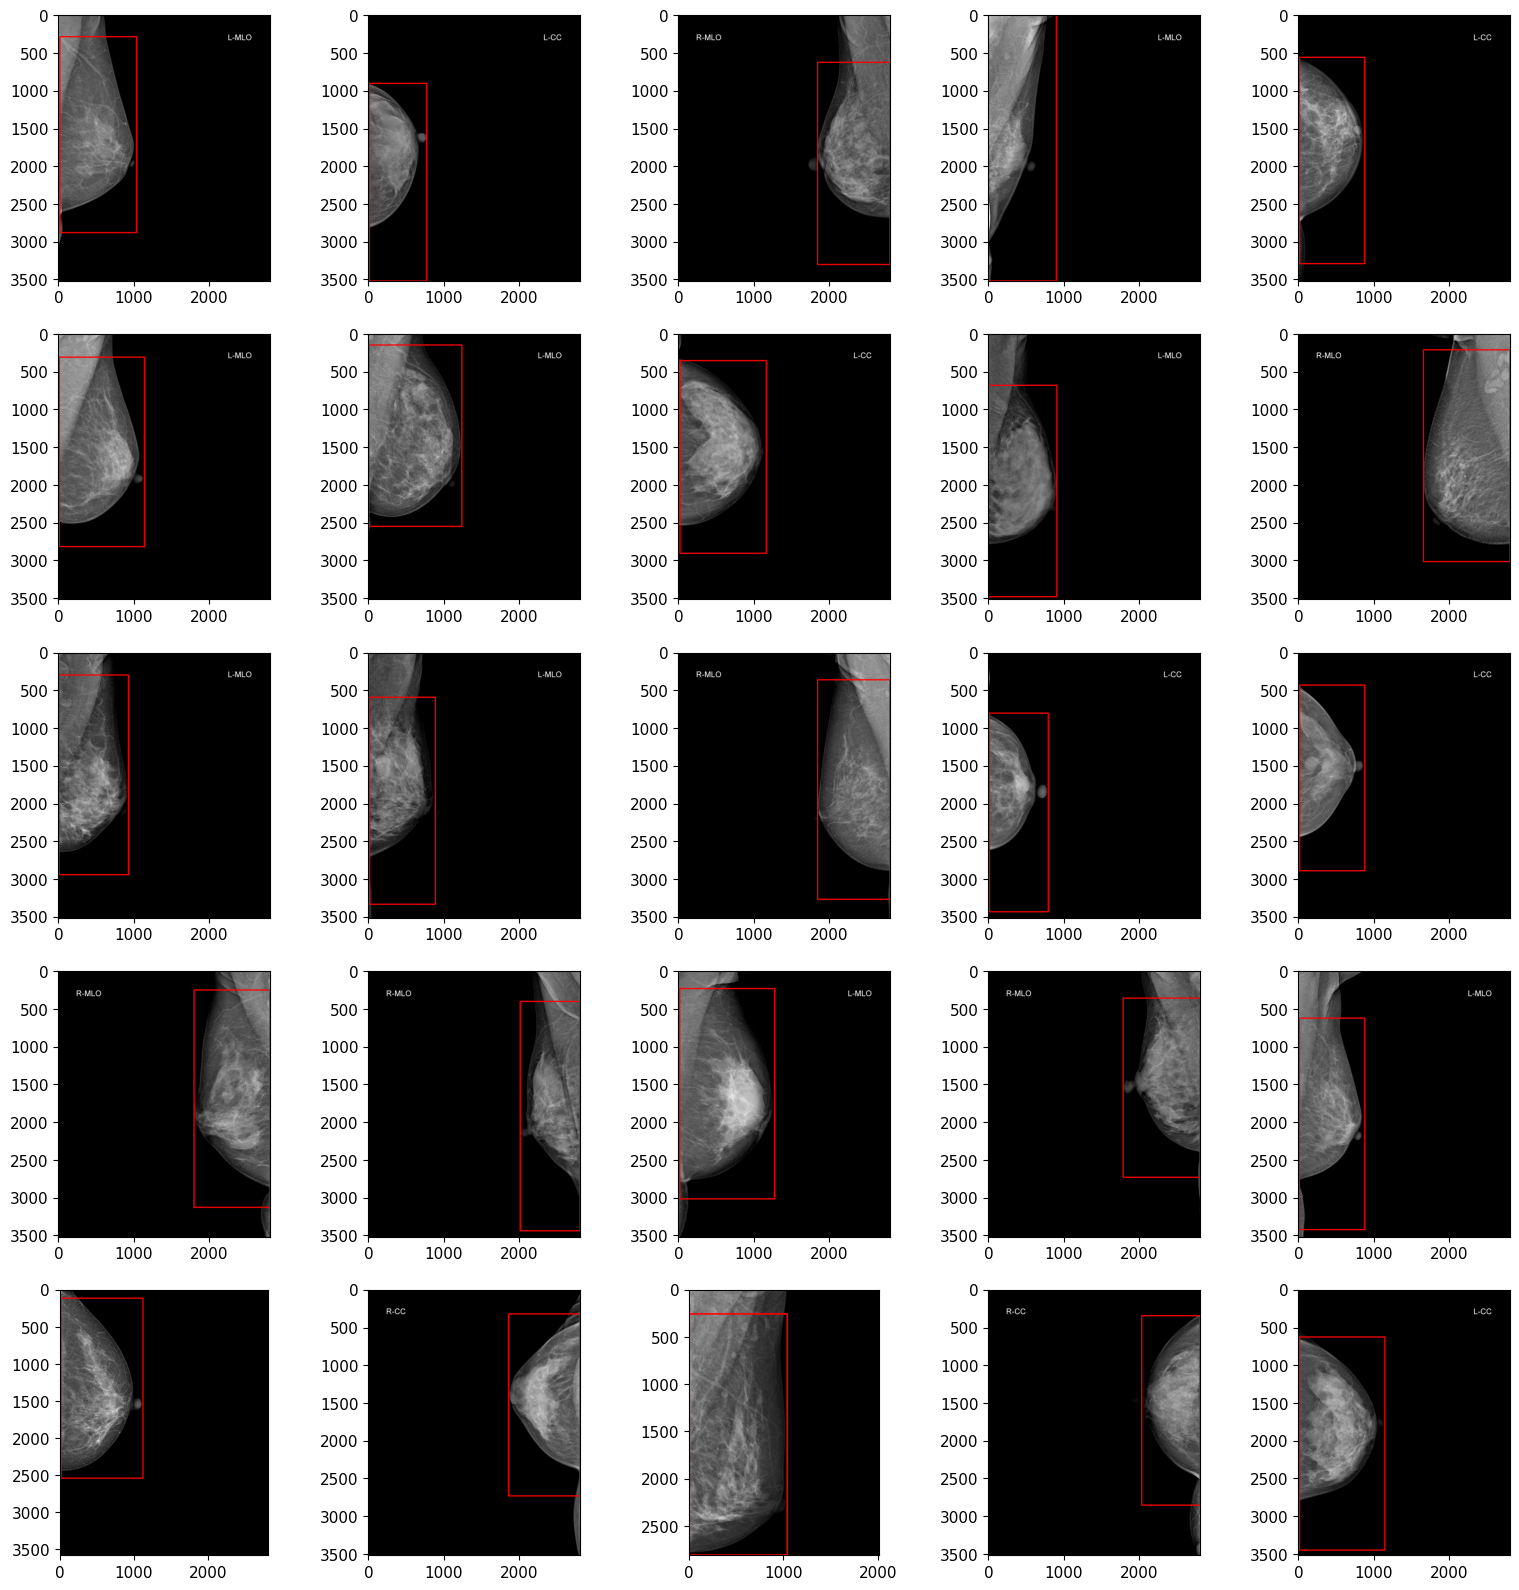

In [9]:
%matplotlib inline
images = []

all_results = []
for img_file in random.sample(file_list, 25):  # it is fixed to 16 random predictions - if you want to change it remeber to change plot_roi as well

    # Read file from file
    image = cv2.imread(str(img_file))

    # Convert results to Pandas style
    xmin, ymin, xmax, ymax = get_roi_coordinates(image, model)

    images.append(cv2.rectangle(image, (xmin, ymin, xmax, ymax), (255,0,0), 15))
    all_results.append((xmin, ymin, xmax, ymax))

# Plot result
fig, axes = plt.subplots(5, 5, figsize=(20,20))

for idx, image in enumerate(images):
    i = idx % 5
    j = idx // 5
    axes[i, j].imshow(image)

plt.subplots_adjust(wspace=0, hspace=.2)
plt.show()

In [10]:
start = time.time()
crop_info = []
for filepath in tqdm(file_list):  # it is fixed to 16 random predictions - if you want to change it remeber to change plot_roi as well

    # Read file from file
    image = cv2.imread(str(filepath))

    # Convert results to Pandas style
    xmin, ymin, xmax, ymax = get_roi_coordinates(image, model)
    crop_info.append({'image_id':filepath.stem,'xmin':xmin, 'ymin':ymin, 'xmax':xmax, 'ymax':ymax})
end = time.time()
print('time_elapsed:', (end-start))

100%|██████████| 3476/3476 [42:17<00:00,  1.37it/s]

time_elapsed: 2537.907180786133


In [11]:
import csv

def list_of_dicts_to_csv(data, filename):
    keys = data[0].keys()  # Assuming all dictionaries have the same keys

    with open(filename, 'w', newline='') as csv_file:
        writer = csv.DictWriter(csv_file, fieldnames=keys)
        writer.writeheader()
        writer.writerows(data)

# Convert list of dictionaries to CSV
list_of_dicts_to_csv(crop_info, 'roi_info.csv')
